# Capstone Project: Passenger Demand Forecasting and Analysis for Rail Transportation: A Case Study    u
Department of Data Science, The University of Wisconsin - La Cro, se
DS785 - Caps, one
Dec 08, 2024


# import required packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linprog
import csv
import warnings

In [6]:
warnings.filterwarnings('ignore')

# Data Preparation

In [9]:
# Setting up simulation parameters
np.random.seed(42)  # For reproducibility
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 10, 31)
date_range = pd.date_range(start_date, end_date, freq="D")

# Train schedule details with five trains per day
train_schedules = [
    {"Train_ID": "Acela1", "Departure_Time": "05:00", "Arrival_Time": "09:00"},
    {"Train_ID": "Acela2", "Departure_Time": "08:00", "Arrival_Time": "12:00"},
    {"Train_ID": "Acela3", "Departure_Time": "12:00", "Arrival_Time": "16:00"},
    {"Train_ID": "Acela4", "Departure_Time": "15:00", "Arrival_Time": "19:00"},
    {"Train_ID": "Acela5", "Departure_Time": "22:00", "Arrival_Time": "02:00"}  # Late night train
]

# Acela stops with short station codes and approximate travel times in minutes from the departure station (Boston)
stations = ["BOS", "BBY", "RTE", "PVD", "NHV", "STM", "NYP"]
station_times = {
    "BOS": 0,
    "BBY": 15,
    "RTE": 30,
    "PVD": 90,
    "NHV": 180,
    "STM": 240,
    "NYP": 300
}

# Define ticket classes without "General"
ticket_classes = ["Economy", "Business", "First Class"]
peak_hours = ["08:00", "12:00", "15:00", "19:00"]
night_hours = ["00:00", "01:00", "02:00", "03:00", "04:00"]

# Demand modifiers
seasonal_demand = {"Winter": 0.8, "Spring": 1.0, "Summer": 1.2, "Autumn": 1.0}
weekday_multiplier = 1.1  # Higher demand on weekdays
weekend_multiplier = 0.9  # Lower demand on weekends
holiday_demand = 1.5  # Increased demand on holidays
peak_hour_multiplier = 1.3  # Higher demand during peak hours
night_hour_multiplier = 0.7  # Reduced demand during late-night hours

# Major holidays for 2023
holidays = [
    datetime(2023, 1, 1),  # New Year's Day
    datetime(2023, 7, 4),  # Independence Day
    datetime(2023, 11, 23), # Thanksgiving
    datetime(2023, 12, 25)  # Christmas
]

# Base seat allocation capacities by segment, higher for longer distances
base_capacities = {
    "short": 50,   # Short segments (e.g., BOS-BBY)
    "medium": 100,  # Medium segments (e.g., BBY-PVD)
    "long": 200    # Long segments (e.g., NHV-NYP)
}

# Generate all possible departure and arrival station pairs (legs)
legs = []
for i in range(len(stations) - 1):
    for j in range(i + 1, len(stations)):
        departure_station = stations[i]
        arrival_station = stations[j]
        segment_type = ("short" if j - i == 1 else "medium" if j - i == 2 else "long")
        legs.append((departure_station, arrival_station, segment_type))

# Generating the dataset with capacity constraints and booking adjustments
data = []
for date in date_range:
    day_of_week = date.weekday()
    season = ("Winter" if date.month in [12, 1, 2] else
              "Spring" if date.month in [3, 4, 5] else
              "Summer" if date.month in [6, 7, 8] else
              "Autumn")
    
    # Determine demand multiplier for the day
    demand_multiplier = seasonal_demand[season]
    demand_multiplier *= weekday_multiplier if day_of_week < 5 else weekend_multiplier
    if date in holidays:
        demand_multiplier *= holiday_demand

    for schedule in train_schedules:
        departure_time = datetime.strptime(schedule["Departure_Time"], "%H:%M")

        for departure_station, arrival_station, segment_type in legs:
            base_capacity = base_capacities[segment_type]

            # Calculate times for the current segment
            dep_time = (departure_time + timedelta(minutes=station_times[departure_station])).strftime("%H:%M")
            arr_time = (departure_time + timedelta(minutes=station_times[arrival_station])).strftime("%H:%M")

            # Adjust demand based on peak, night, and seasonal modifiers
            if dep_time in peak_hours:
                capacity = int(base_capacity * demand_multiplier * peak_hour_multiplier)
            elif dep_time in night_hours:
                capacity = int(base_capacity * demand_multiplier * night_hour_multiplier)
            else:
                capacity = int(base_capacity * demand_multiplier)

            # Minimum seat allocation by class
            economy_count = max(np.random.poisson(0.4 * capacity), 15)
            business_count = max(np.random.poisson(0.2 * capacity), 5)
            first_class_count = max(np.random.poisson(0.1 * capacity), 5)

            # Adjust based on segment type, favoring higher Business and First Class counts for longer legs
            if segment_type == "medium":
                business_count += np.random.randint(3, 8)
                first_class_count += np.random.randint(2, 5)
            elif segment_type == "long":
                business_count += np.random.randint(5, 10)
                first_class_count += np.random.randint(5, 10)

            # Ensure passenger counts do not exceed total capacity
            total_allocated_seats = min(capacity, economy_count + business_count + first_class_count)
            economy_count = min(economy_count, total_allocated_seats - (business_count + first_class_count))
            business_count = min(business_count, total_allocated_seats - economy_count - first_class_count)
            first_class_count = min(first_class_count, total_allocated_seats - economy_count - business_count)

            # Calculate total capacity as 100% to 125% of passenger count to ensure it is higher or equal to passenger count
            economy_capacity = int(np.random.uniform(1.0, 1.25) * economy_count)
            business_capacity = int(np.random.uniform(1.0, 1.25) * business_count)
            first_class_capacity = int(np.random.uniform(1.0, 1.25) * first_class_count)

            # Append data for each ticket class
            data.append({
                "Date": date,
                "Train_ID": schedule["Train_ID"],
                "Departure_Station": departure_station,
                "Arrival_Station": arrival_station,
                "Scheduled_Departure_Time": dep_time,
                "Scheduled_Arrival_Time": arr_time,
                "Ticket_Class": "Economy",
                "Passenger_Count": economy_count,
                "Total_Capacity": economy_capacity
            })
            data.append({
                "Date": date,
                "Train_ID": schedule["Train_ID"],
                "Departure_Station": departure_station,
                "Arrival_Station": arrival_station,
                "Scheduled_Departure_Time": dep_time,
                "Scheduled_Arrival_Time": arr_time,
                "Ticket_Class": "Business",
                "Passenger_Count": business_count,
                "Total_Capacity": business_capacity
            })
            data.append({
                "Date": date,
                "Train_ID": schedule["Train_ID"],
                "Departure_Station": departure_station,
                "Arrival_Station": arrival_station,
                "Scheduled_Departure_Time": dep_time,
                "Scheduled_Arrival_Time": arr_time,
                "Ticket_Class": "First Class",
                "Passenger_Count": first_class_count,
                "Total_Capacity": first_class_capacity
            })

# Create DataFrame from the generated data
simulated_acela_passenger_data = pd.DataFrame(data)

# Display the DataFrame
simulated_acela_passenger_data.head(30)
# Save the DataFrame to a CSV file
simulated_acela_passenger_data.to_csv("acela_passenger_data_2023_20241.csv", index=False)


# Load the dataset

In [11]:
file_path = 'acela_passenger_data_2023_2024.csv'
train_data = pd.read_csv(file_path)

# Monthly trend analysis

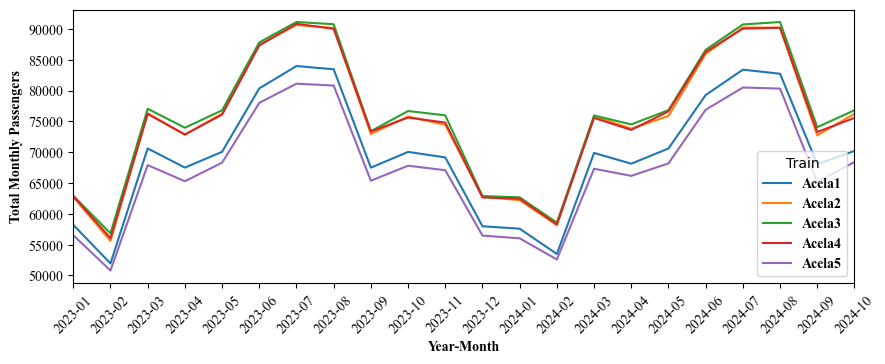

In [13]:

# Convert the 'Date' column to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Extract month and year from the 'Date' column
train_data['YearMonth'] = train_data['Date'].dt.to_period('M')

# Group the data by Train_ID and YearMonth to calculate the monthly passenger count for each train
monthly_trend = train_data.groupby(['Train_ID', 'YearMonth'])['Passenger_Count'].sum().reset_index()

# Plotting the monthly trend for each train
plt.figure(figsize=(9, 4))

train_ids = monthly_trend['Train_ID'].unique()

# Plot trends for each train
for train_id in train_ids:
    train_monthly_data = monthly_trend[monthly_trend['Train_ID'] == train_id]
    plt.plot(train_monthly_data['YearMonth'].astype(str), train_monthly_data['Passenger_Count'], label=train_id)

# Adding labels and legend
plt.xlabel('Year-Month', fontname='Times New Roman', fontweight='bold')
plt.ylabel('Total Monthly Passengers', fontname='Times New Roman', fontweight='bold')
plt.xticks(rotation=45, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.legend(title='Train', loc='lower right', prop={'family': 'Times New Roman', 'weight': 'bold'})
plt.tight_layout(pad=2)

# Adjust x-axis limits to eliminate gaps at the start and end
plt.xlim(monthly_trend['YearMonth'].min().strftime('%Y-%m'), monthly_trend['YearMonth'].max().strftime('%Y-%m'))

# Display the plot
plt.show()


# Weekdays vs. Weekends Demand

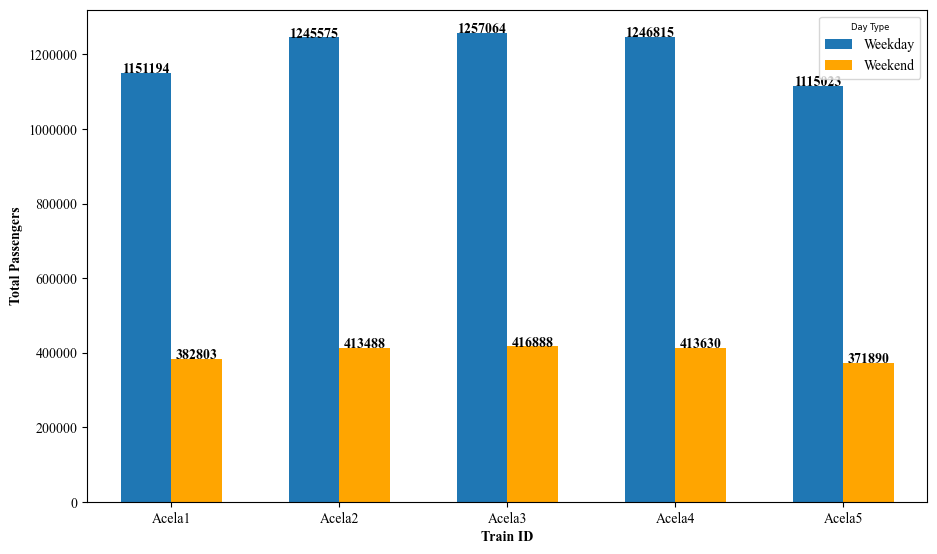

In [15]:
# Convert the 'Date' column to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Extract the day of the week from the 'Date' column
train_data['DayOfWeek'] = train_data['Date'].dt.day_name()

# Classify days into 'Weekday' or 'Weekend'
train_data['DayType'] = train_data['DayOfWeek'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Group the data by Train_ID and DayType to calculate the total passenger count for weekdays and weekends
weekday_vs_weekend = train_data.groupby(['Train_ID', 'DayType'])['Passenger_Count'].sum().reset_index()

# Plotting the Weekdays vs. Weekends demand for all trains using bar plot
plt.figure(figsize=(10, 6))

train_ids = weekday_vs_weekend['Train_ID'].unique()
bar_width = 0.3
index = np.arange(len(train_ids))

# Define colors for Weekday and Weekend
colors = {'Weekday': '#1f77b4', 'Weekend': 'orange'}

# Plot trends for each train - Weekdays vs Weekends
for i, train_id in enumerate(train_ids):
    train_data_weekday = weekday_vs_weekend[(weekday_vs_weekend['Train_ID'] == train_id) & (weekday_vs_weekend['DayType'] == 'Weekday')]
    train_data_weekend = weekday_vs_weekend[(weekday_vs_weekend['Train_ID'] == train_id) & (weekday_vs_weekend['DayType'] == 'Weekend')]
    
    plt.bar(i - bar_width/2, train_data_weekday['Passenger_Count'], bar_width, color=colors['Weekday'], label='Weekday' if i == 0 else "", linewidth=1.5)
    plt.bar(i + bar_width/2, train_data_weekend['Passenger_Count'], bar_width, color=colors['Weekend'], label='Weekend' if i == 0 else "")

    # Adding numbers on top of the bars
    if not train_data_weekday.empty:
        plt.text(i - bar_width/2, train_data_weekday['Passenger_Count'].values[0] + 10, 
                 f"{train_data_weekday['Passenger_Count'].values[0]:.0f}", 
                 ha='center', fontname='Times New Roman', fontsize=10, fontweight='bold')
    if not train_data_weekend.empty:
        plt.text(i + bar_width/2, train_data_weekend['Passenger_Count'].values[0] + 10, 
                 f"{train_data_weekend['Passenger_Count'].values[0]:.0f}", 
                 ha='center', fontname='Times New Roman', fontsize=10, fontweight='bold')

# Adding labels, title, and legend
plt.xlabel('Train ID', fontname='Times New Roman', fontweight='bold')
plt.ylabel('Total Passengers', fontname='Times New Roman', fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')  # Remove scientific notation
#plt.title('Average Passenger Demand: Weekdays vs. Weekends', fontname='Times New Roman', fontweight='bold')
plt.xticks(index, train_ids, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.legend(title='Day Type', fontsize=6, title_fontsize=6, prop={'family': 'Times New Roman'})
plt.tight_layout(pad=3)
plt.xlim(-0.5, len(train_ids) - 0.5)  # Remove gap at the beginning and end
plt.subplots_adjust(left=0.08, right=0.92, top=0.92, bottom=0.1)  # Adjust spacing to reduce gaps

# Display the plot
plt.show()

# Passenger Demand: Peak vs. Non-Peak Hours

In [17]:

file_path = 'acela_passenger_data_2023_2024.csv'
data = pd.read_csv(file_path)
# Filter data for Acela1 (peak hours) and Acela5 (non-peak hours)
acela1_data = data[data['Train_ID'] == 'Acela1']
acela5_data = data[data['Train_ID'] == 'Acela5']

# Group data by Departure_Station and Ticket_Class, calculate average passenger count for Acela1 and Acela5
acela1_station_avg = acela1_data.groupby(['Departure_Station', 'Ticket_Class'])['Passenger_Count'].mean().reset_index()
acela5_station_avg = acela5_data.groupby(['Departure_Station', 'Ticket_Class'])['Passenger_Count'].mean().reset_index()

# Plotting all stations in one graph for comparison
plt.figure(figsize=(14, 8))

# Get unique stations
stations = acela1_station_avg['Departure_Station'].unique()

# Plotting data for each station for Acela1 (peak hours)
for station in stations:
    acela1_station = acela1_station_avg[acela1_station_avg['Departure_Station'] == station]
    plt.plot(acela1_station['Ticket_Class'], acela1_station['Passenger_Count'], marker='o', linestyle='-', label=f'Acela1 (Peak) - {station}')

# Plotting data for each station for Acela5 (non-peak hours)
for station in stations:
    acela5_station = acela5_station_avg[acela5_station_avg['Departure_Station'] == station]
    plt.plot(acela5_station['Ticket_Class'], acela5_station['Passenger_Count'], marker='x', linestyle='--', label=f'Acela5 (Non-Peak) - {station}')

# Graph details
#plt.title('Average Passenger demand by Ticket Class for Acela1 vs Acela5 at Each Station')
plt.xlabel('Ticket Class')
plt.ylabel('Average Passenger Count')
plt.xticks(['Economy', 'Business', 'First Class'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


TypeError: list indices must be integers or slices, not str

# capacity utilizaton anlaysis

In [ ]:

# Load the dataset
file_path = 'acela_passenger_data_2023_2024.csv'
train_data = pd.read_csv(file_path)

# Filter the dataset for BOS to NYP route only
# bos_to_nyp_data = train_data[
#     (train_data['Departure_Station'] == 'BOS') & 
#     (train_data['Arrival_Station'] == 'NYP')
# ]

# Grouping the data by 'Train_ID', 'Departure_Station', 'Arrival_Station', and 'Ticket_Class'
# to calculate total passengers and total capacity for each category
bos_nyp_capacity_utilization = train_data.groupby(
    ['Train_ID', 'Departure_Station', 'Arrival_Station', 'Ticket_Class']
).agg(
    Total_Passengers=('Passenger_Count', 'sum'),
    Total_Capacity=('Total_Capacity', 'sum')
).reset_index()

# Calculating capacity utilization percentage
bos_nyp_capacity_utilization['Capacity_Utilization_Percentage'] = (
    (bos_nyp_capacity_utilization['Total_Passengers'] / bos_nyp_capacity_utilization['Total_Capacity']) * 100
)

# Display the capacity utilization dataframe
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the Capacity Utilization for each class for each train
plt.figure(figsize=(12, 8))
sns.barplot(
    data=bos_nyp_capacity_utilization, 
    x='Train_ID', 
    y='Capacity_Utilization_Percentage', 
    hue='Ticket_Class', 
    palette='viridis'
)

# Adding labels, title, and legend
plt.xlabel('Train ID', fontname='Times New Roman', fontweight='bold')
plt.ylabel('Capacity Utilization (%)', fontname='Times New Roman', fontweight='bold')
plt.title('Capacity Utilization Analysis for Each Train and Ticket Class', fontname='Times New Roman', fontweight='bold')
plt.xticks(fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.legend(title='Ticket Class', fontsize=9, title_fontsize=10, prop={'family': 'Times New Roman', 'weight': 'bold'})
plt.tight_layout()

# Display the plot
plt.show()

# Display the calculated capacity utilization data
bos_nyp_capacity_utilization


In [ ]:
# Capacity Utilizatoin in tabular format

In [ ]:

# Load the dataset
file_path = 'acela_passenger_data_2023_2024.csv'
train_data = pd.read_csv(file_path)

# Summarize data by routes to create aggregated passenger demand and capacity for each segment
route_summary = train_data.groupby(['Departure_Station', 'Arrival_Station', 'Ticket_Class']).agg(
    {'Passenger_Count': 'sum', 'Total_Capacity': 'sum'}).reset_index()

# Aggregate data to obtain passenger demand and total capacity for each route
routes = route_summary.groupby(['Departure_Station', 'Arrival_Station']).agg(
    {'Passenger_Count': 'sum', 'Total_Capacity': 'sum'}).reset_index()

# Define parameters for LP
num_routes = len(routes)

# Objective coefficients: Maximize passenger allocation (use negative to convert minimization to maximization)
c = -routes['Passenger_Count'].values

# Constraints: Passenger allocation must not exceed capacity for each route
A_ub = [[1 if j == i else 0 for j in range(num_routes)] for i in range(num_routes)]
b_ub = routes['Total_Capacity'].values

# Introduce an upper bound for capacity utilization (95% of total capacity)
utilization_target = 0.95
b_ub_adjusted = routes['Total_Capacity'] * utilization_target

# Bounds: Allocation must be between 0 and total capacity for each route
x_bounds = [(0, routes.iloc[i]['Total_Capacity']) for i in range(num_routes)]

# Solve the Linear Program with updated capacity constraints
result_adjusted = linprog(c, A_ub=A_ub, b_ub=b_ub_adjusted, bounds=x_bounds, method='highs')

# Check if the optimization was successful
if result_adjusted.success:
    routes['Allocated_Passengers_Adjusted'] = result_adjusted.x.round().astype(int)
    routes['Utilization_Rate_Adjusted (%)'] = (result_adjusted.x / routes['Total_Capacity']) * 100
    routes = routes.round({'Utilization_Rate_Adjusted (%)': 2})
    print(routes)
    # Write the results to a CSV file
    routes.to_csv('simulated_acela_passenger_data-lp-results.csv', index=False)
else:
    print("Optimization failed:", result_adjusted.message)

# K-Means Clustering

In [ ]:
# Load the dataset
file_path = 'acela_passenger_data_2023_2024.csv'
train_data = pd.read_csv(file_path)

# Preprocess data for clustering
# Grouping by route and calculating the total passenger count and capacity per segment
train_data['Route'] = train_data['Departure_Station'] + '-' + train_data['Arrival_Station']
route_demand = train_data.groupby('Route').agg({'Passenger_Count': 'sum', 'Total_Capacity': 'sum'}).reset_index()

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(route_demand[['Passenger_Count', 'Total_Capacity']])

# Apply K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
route_demand['Cluster'] = clusters

# Assign descriptive cluster names
cluster_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
route_demand['Cluster_Name'] = route_demand['Cluster'].map(cluster_mapping)

# Filter the dataset to get 3 high-demand routes, 5 medium-demand routes, and 7 low-demand routes
high_routes = route_demand[route_demand['Cluster_Name'] == 'High'].head(3)
medium_routes = route_demand[route_demand['Cluster_Name'] == 'Medium'].head(5)
low_routes = route_demand[route_demand['Cluster_Name'] == 'Low'].head(7)

# Combine the filtered data into a single DataFrame for better overview
selected_routes = pd.concat([high_routes, medium_routes, low_routes]).reset_index(drop=True)

# Convert the cluster names to numerical codes for plotting purposes
cluster_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
selected_routes['Cluster_Code'] = selected_routes['Cluster_Name'].map(cluster_mapping)

# Create a bar graph to visualize the selected routes and their cluster codes
plt.figure(figsize=(9, 4))
plt.bar(selected_routes['Route'], selected_routes['Cluster_Code'], color='dodgerblue')
plt.xlabel('Route')
plt.ylabel('Cluster (1: Low, 2: Medium, 3: High)')
plt.title('Demand Clusters of Selected Routes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# linear programming

In [ ]:
# Load the dataset
file_path = 'acela_passenger_data_2023_2024.csv'
train_data = pd.read_csv(file_path)

# Summarize data by routes to create aggregated passenger demand and capacity for each segment
route_summary = train_data.groupby(['Departure_Station', 'Arrival_Station', 'Ticket_Class']).agg(
    {'Passenger_Count': 'sum', 'Total_Capacity': 'sum'}).reset_index()

# Aggregate data to obtain passenger demand and total capacity for each route
routes = route_summary.groupby(['Departure_Station', 'Arrival_Station']).agg(
    {'Passenger_Count': 'sum', 'Total_Capacity': 'sum'}).reset_index()

# Define parameters for LP
num_routes = len(routes)

# Objective coefficients: Maximize passenger allocation (use negative to convert minimization to maximization)
c = -routes['Passenger_Count'].values

# Constraints: Passenger allocation must not exceed capacity for each route
A_ub = [[1 if j == i else 0 for j in range(num_routes)] for i in range(num_routes)]
b_ub = routes['Total_Capacity'].values

# Introduce an upper bound for capacity utilization (95% of total capacity)
utilization_target = 0.95
b_ub_adjusted = routes['Total_Capacity'] * utilization_target

# Bounds: Allocation must be between 0 and total capacity for each route
x_bounds = [(0, routes.iloc[i]['Total_Capacity']) for i in range(num_routes)]

# Solve the Linear Program with updated capacity constraints
result_adjusted = linprog(c, A_ub=A_ub, b_ub=b_ub_adjusted, bounds=x_bounds, method='highs')

# Check if the optimization was successful
if result_adjusted.success:
    routes['Allocated_Passengers_Adjusted'] = result_adjusted.x.round().astype(int)
    routes['Utilization_Rate_Adjusted (%)'] = (result_adjusted.x / routes['Total_Capacity']) * 100
    routes = routes.round({'Utilization_Rate_Adjusted (%)': 2})
    
    # Plotting the results
    fig, ax = plt.subplots(figsize=(10, 6))
    x_labels = routes['Departure_Station'] + " - " + routes['Arrival_Station']
    
    # Bar chart for allocated passengers
    ax.bar(x_labels, routes['Allocated_Passengers_Adjusted'], color='b', alpha=0.7, label='Allocated Passengers')
    
    # Line chart for utilization rate
    ax2 = ax.twinx()
    ax2.plot(x_labels, routes['Utilization_Rate_Adjusted (%)'], color='r', marker='o', linestyle='-', label='Utilization Rate (%)')
    
    # Setting labels
    ax.set_xlabel('Route', fontsize=12)
    ax.set_ylabel('Allocated Passengers', color='b', fontsize=12)
    ax2.set_ylabel('Utilization Rate (%)', color='r', fontsize=12)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    # Title and legend
    plt.title('Linear Programming Seat Allocation Optimization Results', fontsize=14)
    fig.tight_layout()
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Show the plot
    plt.show()
else:
    print("Optimization failed:", result_adjusted.message)

# modelling methodology

# random forest

In [ ]:
# Load dataset
file_path = 'acela_passenger_data_2023_2024.csv'
acela_data = pd.read_csv(file_path)

# Prepare the dataset for Random Forest modeling
# Encoding categorical features
acela_data_encoded = acela_data.copy()
acela_data_encoded['Departure_Station'] = acela_data_encoded['Departure_Station'].astype('category').cat.codes
acela_data_encoded['Arrival_Station'] = acela_data_encoded['Arrival_Station'].astype('category').cat.codes
acela_data_encoded['Ticket_Class'] = acela_data_encoded['Ticket_Class'].astype('category').cat.codes

# Splitting features and target
X = acela_data_encoded[['Departure_Station', 'Arrival_Station', 'Ticket_Class', 'Total_Capacity']]
y = acela_data_encoded['Passenger_Count']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation Metrics for Random Forest
rf_mae = mean_absolute_error(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_r_squared = r2_score(y_test, y_pred)

# Display Random Forest Results
print("Random Forest Model Performance Metrics:")
print(f"MAE: {rf_mae:.2f}")
print(f"MSE: {rf_mse:.2f}")
print(f"R-squared (R²): {rf_r_squared:.2f}")

# linear regression

In [ ]:
# Load dataset
file_path = 'acela_passenger_data_2023_2024.csv'
acela_data = pd.read_csv(file_path)

# Group by Date, Train_ID, and Segment to get total passengers and capacity per segment
acela_data['Segment'] = acela_data['Departure_Station'] + '-' + acela_data['Arrival_Station']
grouped_data = acela_data.groupby(['Date', 'Train_ID', 'Segment']).agg(
    {'Passenger_Count': 'sum', 'Total_Capacity': 'sum'}
).reset_index()

# Convert Date to datetime object
grouped_data['Date'] = pd.to_datetime(grouped_data['Date'])

# Set the Date as the index for forecasting purposes
grouped_data.set_index('Date', inplace=True)

# Extract features and target variable
X = grouped_data[['Total_Capacity']]
y = grouped_data['Passenger_Count']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Calculate Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² Score
mse = mean_squared_error(y_test, y_pred).round(2)
mae = mean_absolute_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(2)

# Print error metrics
mse, mae, r2


# Hybrid Model

In [ ]:
# Load dataset
file_path = 'acela_passenger_data_2023_2024.csv'
acela_data = pd.read_csv(file_path)

# Group by train ID, date, and segment to get total passengers and capacity per segment
acela_data['Segment'] = acela_data['Departure_Station'] + '-' + acela_data['Arrival_Station']
grouped_data = acela_data.groupby(['Date', 'Train_ID', 'Segment']).agg(
    {'Passenger_Count': 'sum', 'Total_Capacity': 'sum'}
).reset_index()

# Convert Date to datetime object
grouped_data['Date'] = pd.to_datetime(grouped_data['Date'])

# Set the Date as the index for forecasting purposes
grouped_data.set_index('Date', inplace=True)

# Extract features and target variable
X = grouped_data[['Total_Capacity']]
y = grouped_data['Passenger_Count']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Combine predictions (Simple Averaging for Hybrid Model)
y_pred_hybrid = (y_pred_lr + y_pred_rf) / 2

# Calculate performance metrics for the hybrid model
mse = mean_squared_error(y_test, y_pred_hybrid).round(2)
mae = mean_absolute_error(y_test, y_pred_hybrid).round(2)
r2 = r2_score(y_test, y_pred_hybrid).round(2)

# Create future dates for forecasting
future_dates = pd.date_range(start=grouped_data.index.max() + pd.Timedelta(days=1), periods=30)
future_capacity = np.full((len(future_dates), 1), X['Total_Capacity'].mean())  # Assume average capacity for future

# Make predictions for future dates using both models
y_pred_lr_future = lr_model.predict(future_capacity)
y_pred_rf_future = rf_model.predict(future_capacity)

# Combine predictions (Simple Averaging for Hybrid Model)
y_pred_hybrid_future = (y_pred_lr_future + y_pred_rf_future) / 2

# Create DataFrame for forecasted demand
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Passenger_Count': y_pred_hybrid_future})
forecast_df.set_index('Date', inplace=True)

# Plotting forecasted demand
# plt.figure(figsize=(10, 6))
# plt.plot(grouped_data.index, grouped_data['Passenger_Count'], label='Historical Passenger Count', color='blue')
# plt.plot(forecast_df.index, forecast_df['Forecasted_Passenger_Count'], label='Hybrid Model Forecasted Passenger Count', color='green')
# plt.xlabel('Date')
# plt.ylabel('Passenger Count')
# plt.title('Hybrid Model Forecast for Passenger Demand')
# plt.legend()
# plt.grid()
# plt.show()

# Display performance metrics
mse, mae, r2


# Chapter 4 - Results and Recommandations

# Scenario 1: Estimating Demand for Late-Night Train Schedules

In [ ]:
# Load dataset
file_path = 'acela_passenger_data_2023_2024.csv'
data = pd.read_csv(file_path)

# Filter data for Acela 2 train departing from Boston Back Bay (BBY) to New York Penn Station (NYP) at 08:15 AM
filtered_data = data[
    (data['Train_ID'] == 'Acela5') & 
    (data['Departure_Station'] == 'BOS') & 
    (data['Arrival_Station'] == 'NYP') & 
    (data['Scheduled_Departure_Time'] == '22:00')
]

# Convert Date to datetime format and extract necessary features for forecasting
filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])
filtered_data['Day_of_Week'] = filtered_data['Date'].dt.dayofweek
filtered_data['Month'] = filtered_data['Date'].dt.month

# Define features and target
X = filtered_data[['Day_of_Week', 'Month', 'Total_Capacity']]
y = filtered_data['Passenger_Count']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
linear_model = LinearRegression()
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Train models
linear_model.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# Predictions
linear_predictions = linear_model.predict(X_test)
rf_predictions = random_forest.predict(X_test)

# Create a hybrid model using both Linear Regression and Random Forest
hybrid_model = VotingRegressor(estimators=[
    ('linear', linear_model),
    ('rf', random_forest)
])

# Train the hybrid model
hybrid_model.fit(X_train, y_train)

# Predictions from the hybrid model
hybrid_predictions = hybrid_model.predict(X_test)

# Calculate performance metrics for each model
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

linear_mse, linear_mae, linear_r2 = calculate_metrics(y_test, linear_predictions)
rf_mse, rf_mae, rf_r2 = calculate_metrics(y_test, rf_predictions)
hybrid_mse, hybrid_mae, hybrid_r2 = calculate_metrics(y_test, hybrid_predictions)

# Display metrics
sc1_df_metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Hybrid Model'],
    'MSE': [linear_mse, rf_mse, hybrid_mse],
    'MAE': [linear_mae, rf_mae, hybrid_mae],
    'R^2': [linear_r2, rf_r2, hybrid_r2]
})
#tools.display_dataframe_to_user(name="Model Performance Metrics with Detailed Calculations", dataframe=df_metrics)

# Plotting separate graphs for each model's forecast versus actual passenger count
plt.figure(figsize=(18, 15))

# Creating future data for forecasting passenger demand for the next few months
future_dates = pd.date_range(start='2024-11-01', end='2025-02-28', freq='D')

# Creating future data
future_data = pd.DataFrame({
    'Date': future_dates,
    'Day_of_Week': future_dates.dayofweek,
    'Month': future_dates.month,
    'Total_Capacity': [X['Total_Capacity'].mean()] * len(future_dates)  # Assuming average capacity
})

# Forecast using each model
linear_forecast = linear_model.predict(future_data[['Day_of_Week', 'Month', 'Total_Capacity']])
rf_forecast = random_forest.predict(future_data[['Day_of_Week', 'Month', 'Total_Capacity']])
hybrid_forecast = hybrid_model.predict(future_data[['Day_of_Week', 'Month', 'Total_Capacity']])

# Plotting forecasted passenger demand for the next few months for each model
plt.figure(figsize=(18, 10))

# Linear Regression Forecast
plt.plot(future_dates, linear_forecast, label='Linear Regression Forecast', color='blue', linestyle='--', linewidth=2)

# Random Forest Forecast
plt.plot(future_dates, rf_forecast, label='Random Forest Forecast', color='green', linestyle='--', linewidth=2)

# Hybrid Model Forecast
plt.plot(future_dates, hybrid_forecast, label='Hybrid Model Forecast', color='red', linestyle='--', linewidth=2)

# Adding titles and labels

#plt.title('Late-night 10 PM Passenger Demand for Acela 5', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Display the plot
plt.show()

sc1_df_metrics['MSE'] = sc1_df_metrics['MSE'].round(2)
sc1_df_metrics['MAE'] = sc1_df_metrics['MAE'].round(2)
sc1_df_metrics['R^2'] = sc1_df_metrics['R^2'].round(2)
sc1_df_metrics

# Scenario 2: Weekday Weekend Demand

In [ ]:
# Load dataset
file_path = 'acela_passenger_data_2023_2024.csv'
data = pd.read_csv(file_path)

# Filter data for Acela 2 train departing from Boston (BOS) to NYP at 08:00 AM
filtered_data = data[
    (data['Train_ID'] == 'Acela2') & 
    (data['Departure_Station'] == 'BOS') & 
    (data['Arrival_Station'] == 'NYP') & 
    (data['Scheduled_Departure_Time'] == '08:00')
]

# Convert Date to datetime format and extract necessary features
filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])
filtered_data['Day_of_Week'] = filtered_data['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
filtered_data['Is_Weekend'] = filtered_data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
filtered_data['Month'] = filtered_data['Date'].dt.month

# Define features and target
X = filtered_data[['Day_of_Week', 'Is_Weekend', 'Month', 'Total_Capacity']]
y = filtered_data['Passenger_Count']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
linear_model = LinearRegression()
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
hybrid_model = VotingRegressor(estimators=[
    ('linear', linear_model),
    ('rf', random_forest)
])

# Train models
linear_model.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
hybrid_model.fit(X_train, y_train)

# Predictions
linear_predictions = linear_model.predict(X_test)
rf_predictions = random_forest.predict(X_test)
hybrid_predictions = hybrid_model.predict(X_test)

# Calculate performance metrics for each model
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

linear_mse, linear_mae, linear_r2 = calculate_metrics(y_test, linear_predictions)
rf_mse, rf_mae, rf_r2 = calculate_metrics(y_test, rf_predictions)
hybrid_mse, hybrid_mae, hybrid_r2 = calculate_metrics(y_test, hybrid_predictions)

# Compile metrics into a DataFrame
sc2_metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Hybrid Model'],
    'MSE': [linear_mse, rf_mse, hybrid_mse],
    'MAE': [linear_mae, rf_mae, hybrid_mae],
    'R^2': [linear_r2, rf_r2, hybrid_r2]
})

# # Display metrics
# def display_metrics():
#     print("Model Performance Metrics:")
#     print(sc2_metrics_df)

# Plot actual vs predicted for each model
plt.figure(figsize=(18, 15))

# # Display metrics
# display_metrics()

# Forecast passenger demand for the next few months
future_dates = pd.date_range(start='2024-11-01', end='2025-02-28', freq='D')
future_data = pd.DataFrame({
    'Date': future_dates,
    'Day_of_Week': future_dates.dayofweek,
    'Is_Weekend': future_dates.dayofweek.map(lambda x: 1 if x >= 5 else 0),
    'Month': future_dates.month,
    'Total_Capacity': [X['Total_Capacity'].mean()] * len(future_dates)  # Assuming average capacity
})

# Forecast using each model
linear_forecast = linear_model.predict(future_data[['Day_of_Week', 'Is_Weekend', 'Month', 'Total_Capacity']])
rf_forecast = random_forest.predict(future_data[['Day_of_Week', 'Is_Weekend', 'Month', 'Total_Capacity']])
hybrid_forecast = hybrid_model.predict(future_data[['Day_of_Week', 'Is_Weekend', 'Month', 'Total_Capacity']])

# Plotting forecasted passenger demand for the next few months
plt.figure(figsize=(18, 10))

# Linear Regression Forecast
plt.plot(future_dates, linear_forecast, label='Linear Regression Forecast', color='blue', linestyle='--', linewidth=2)

# Random Forest Forecast
plt.plot(future_dates, rf_forecast, label='Random Forest Forecast', color='green', linestyle='--', linewidth=2)

# Hybrid Model Forecast
plt.plot(future_dates, hybrid_forecast, label='Hybrid Model Forecast', color='red', linestyle='--', linewidth=2)

# Adding titles and labels
#plt.title('Weekday Weekend forecast for Acela 2 08:00 AM train', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Display the plot
plt.show()

sc2_metrics_df['MSE'] = sc2_metrics_df['MSE'].round(2)
sc2_metrics_df['MAE'] = sc2_metrics_df['MAE'].round(2)
sc2_metrics_df['R^2'] = sc2_metrics_df['R^2'].round(2)
sc2_metrics_df

# Scenario 3: Passenger Demand for Economy and Business Classes

In [ ]:
# Load dataset
file_path = 'acela_passenger_data_2023_2024.csv'
data = pd.read_csv(file_path)

# Filter data for Acela 1 train departing from Boston (BOS) to NYP at 5 AM
filtered_data = data[
    (data['Train_ID'] == 'Acela1') &
    (data['Departure_Station'] == 'BOS') &
    (data['Arrival_Station'] == 'NYP') &
    (data['Scheduled_Departure_Time'] == '05:00')
]

# Separate Economy and Business Class data
economy_data = filtered_data[filtered_data['Ticket_Class'] == 'Economy']
business_data = filtered_data[filtered_data['Ticket_Class'] == 'Business']

# Function to process data and train models
def forecast_demand(class_data, class_name):
    # Convert Date to datetime format and extract necessary features
    class_data['Date'] = pd.to_datetime(class_data['Date'])
    class_data['Day_of_Week'] = class_data['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
    class_data['Is_Weekend'] = class_data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
    class_data['Month'] = class_data['Date'].dt.month

    # Define features and target
    X = class_data[['Day_of_Week', 'Is_Weekend', 'Month', 'Total_Capacity']]
    y = class_data['Passenger_Count']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    linear_model = LinearRegression()
    random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
    hybrid_model = VotingRegressor(estimators=[
        ('linear', linear_model),
        ('rf', random_forest)
    ])

    # Train models
    linear_model.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    hybrid_model.fit(X_train, y_train)

    # Predictions
    linear_predictions = linear_model.predict(X_test)
    rf_predictions = random_forest.predict(X_test)
    hybrid_predictions = hybrid_model.predict(X_test)

    # Calculate performance metrics for each model
    def calculate_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return mse, mae, r2

    linear_mse, linear_mae, linear_r2 = calculate_metrics(y_test, linear_predictions)
    rf_mse, rf_mae, rf_r2 = calculate_metrics(y_test, rf_predictions)
    hybrid_mse, hybrid_mae, hybrid_r2 = calculate_metrics(y_test, hybrid_predictions)

    # Compile metrics into a DataFrame
    metrics_df = pd.DataFrame({
        'Model': ['Linear Regression', 'Random Forest', 'Hybrid Model'],
        'MSE': [linear_mse, rf_mse, hybrid_mse],
        'MAE': [linear_mae, rf_mae, hybrid_mae],
        'R^2': [linear_r2, rf_r2, hybrid_r2]
    })

    # Plot actual vs predicted for each model
    plt.figure(figsize=(18, 15))


    # Forecast for next few months
    future_dates = pd.date_range(start='2024-11-01', end='2025-02-28', freq='D')
    future_data = pd.DataFrame({
        'Date': future_dates,
        'Day_of_Week': future_dates.dayofweek,
        'Is_Weekend': future_dates.dayofweek.map(lambda x: 1 if x >= 5 else 0),
        'Month': future_dates.month,
        'Total_Capacity': [X['Total_Capacity'].mean()] * len(future_dates)  # Assuming average capacity
    })

    # Forecast using each model
    linear_forecast = linear_model.predict(future_data[['Day_of_Week', 'Is_Weekend', 'Month', 'Total_Capacity']])
    rf_forecast = random_forest.predict(future_data[['Day_of_Week', 'Is_Weekend', 'Month', 'Total_Capacity']])
    hybrid_forecast = hybrid_model.predict(future_data[['Day_of_Week', 'Is_Weekend', 'Month', 'Total_Capacity']])

    # Plotting forecasted passenger demand for the next few months
    plt.figure(figsize=(18, 10))

    # Linear Regression Forecast
    plt.plot(future_dates, linear_forecast, label='Linear Regression Forecast', color='blue', linestyle='--', linewidth=2)

    # Random Forest Forecast
    plt.plot(future_dates, rf_forecast, label='Random Forest Forecast', color='green', linestyle='--', linewidth=2)

    # Hybrid Model Forecast
    plt.plot(future_dates, hybrid_forecast, label='Hybrid Model Forecast', color='red', linestyle='--', linewidth=2)

    # Adding titles and labels
    #plt.title(f'Acela 1 Forecasted Passenger Demand for {class_name} (Next Few Months)', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Passenger Count', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)

    # Display the plot
    plt.show()

    return metrics_df

# Forecast for Economy Class
sc3_economy_metrics = forecast_demand(economy_data, "Economy Class")

# Forecast for Business Class
sc3_business_metrics = forecast_demand(business_data, "Business Class")

# Display performance metrics
sc3_economy_metrics, sc3_business_metrics

# Scenario 4: Monthly Passenger Demand Forecast for Acela Trains

In [ ]:
# Load dataset
file_path = 'acela_passenger_data_2023_2024.csv'
data = pd.read_csv(file_path)

# Aggregate monthly demand for all trains
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
monthly_demand = data.groupby(['Month', 'Train_ID'])[['Passenger_Count']].sum().reset_index()

# Prepare data for training and forecasting
train_data = monthly_demand.pivot(index='Month', columns='Train_ID', values='Passenger_Count').fillna(0)
train_data = train_data.reset_index()

# Function to train and forecast for each train
def forecast_monthly_demand(train_data, train_id):
    train_data['Train_ID'] = train_id
    y = train_data[train_id]
    X = train_data[['Month']]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    linear_model = LinearRegression()
    random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
    hybrid_model = VotingRegressor(estimators=[
        ('linear', linear_model),
        ('rf', random_forest)
    ])

    # Train models
    linear_model.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    hybrid_model.fit(X_train, y_train)

    # Predictions
    linear_predictions = linear_model.predict(X_test)
    rf_predictions = random_forest.predict(X_test)
    hybrid_predictions = hybrid_model.predict(X_test)

    # Calculate performance metrics for each model
    def calculate_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return mse, mae, r2

    linear_mse, linear_mae, linear_r2 = calculate_metrics(y_test, linear_predictions)
    rf_mse, rf_mae, rf_r2 = calculate_metrics(y_test, rf_predictions)
    hybrid_mse, hybrid_mae, hybrid_r2 = calculate_metrics(y_test, hybrid_predictions)

    metrics_df = pd.DataFrame({
        'Model': ['Linear Regression', 'Random Forest', 'Hybrid Model'],
        'MSE': [linear_mse, rf_mse, hybrid_mse],
        'MAE': [linear_mae, rf_mae, hybrid_mae],
        'R^2': [linear_r2, rf_r2, hybrid_r2]
    })

    # Future forecasting
    future_months = pd.DataFrame({'Month': np.arange(1, 13)})
    linear_forecast = linear_model.predict(future_months)
    rf_forecast = random_forest.predict(future_months)
    hybrid_forecast = hybrid_model.predict(future_months)

    # Plotting forecast
    plt.figure(figsize=(10, 6))

    # Linear Regression Forecast
    #plt.plot(future_months['Month'], linear_forecast, label='Linear Regression Forecast', color='blue', linestyle='--', linewidth=2)

    # Random Forest Forecast
    plt.plot(future_months['Month'], rf_forecast, label='Random Forest Forecast', color='green', linestyle='--', linewidth=2)

    # Hybrid Model Forecast
    plt.plot(future_months['Month'], hybrid_forecast, label='Hybrid Model Forecast', color='red', linestyle='--', linewidth=2)

    #plt.title(f'Monthly Passenger Demand Forecast for {train_id}', fontsize=16)
    plt.xlabel('Month', fontsize=10)
    plt.ylabel('Passenger Count', fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)
    plt.show()

    return metrics_df

# Forecast and evaluate for all trains
all_metrics = {}
for train_id in train_data.columns[1:]:
    print(f"Processing Train: {train_id}")
    metrics = forecast_monthly_demand(train_data, train_id)
    all_metrics[train_id] = metrics

# Combine performance metrics
sc4_metrics_df = pd.concat(all_metrics, axis=0)

sc4_metrics_df['MSE'] = sc4_metrics_df['MSE'].round(2)
sc4_metrics_df['MAE'] = sc4_metrics_df['MAE'].round(2)
sc4_metrics_df['R^2'] = sc4_metrics_df['R^2'].round(2)
sc4_metrics_df


# Scenario 4: Monthly Passenger Demand Forecast for Acela Trains

In [ ]:
# Aggregate monthly demand for all trains
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
monthly_demand = data.groupby(['Month', 'Train_ID'])[['Passenger_Count']].sum().reset_index()

# Prepare data for training and forecasting
train_data = monthly_demand.pivot(index='Month', columns='Train_ID', values='Passenger_Count').fillna(0)
train_data = train_data.reset_index()

# Function to train and forecast for each train
def forecast_monthly_demand(train_data, train_id):
    train_data['Train_ID'] = train_id
    y = train_data[train_id]
    X = train_data[['Month']]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    linear_model = LinearRegression()
    random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
    hybrid_model = VotingRegressor(estimators=[
        ('linear', linear_model),
        ('rf', random_forest)
    ])

    # Train models
    linear_model.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    hybrid_model.fit(X_train, y_train)

    # Future forecasting
    future_months = pd.DataFrame({'Month': np.arange(1, 13)})
    linear_forecast = linear_model.predict(future_months)
    rf_forecast = random_forest.predict(future_months)
    hybrid_forecast = hybrid_model.predict(future_months)

    return future_months['Month'], linear_forecast, rf_forecast, hybrid_forecast

# Plotting all forecasts on one graph
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red', 'orange', 'purple']  # Colors for different trains
for i, train_id in enumerate(train_data.columns[1:]):
    print(f"Processing Train: {train_id}")
    months, linear_forecast, rf_forecast, hybrid_forecast = forecast_monthly_demand(train_data, train_id)
    color = colors[i % len(colors)]

    # Plot forecasts for each model
    plt.plot(months, linear_forecast, label=f'{train_id} Linear', linestyle='--', color=color, alpha=0.7)
    plt.plot(months, rf_forecast, label=f'{train_id} Random Forest', linestyle='-.', color=color, alpha=0.9)
    plt.plot(months, hybrid_forecast, label=f'{train_id} Hybrid', linestyle='-', color=color, linewidth=2)

#plt.title('Monthly Passenger Demand Forecast for All Trains and Models', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Passenger Count', fontsize=12)
plt.legend(loc='upper right', fontsize=7, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Consolidate performance metrics for all scenarios
scenarios = ['Late-Night Schedule', 'Economy Class', 'Business Class', 'Weekday vs Weekend', 'Monthly Forecast']
metrics = {
    'Scenario': [],
    'Model': [],
    'MSE': [],
    'MAE': [],
    'R^2': []
}

# Assuming metrics for each scenario are stored in separate DataFrames (scenario_metrics)
scenario_metrics = [
    sc1_df_metrics,
    sc2_metrics_df,
    sc3_economy_metrics,
    sc3_business_metrics,
    sc4_metrics_df
    # sc5_metrics_df
]

# Combine metrics into one dictionary
for i, scenario_metric in enumerate(scenario_metrics):
    for _, row in scenario_metric.iterrows():
        metrics['Scenario'].append(scenarios[i])
        metrics['Model'].append(row['Model'])
        metrics['MSE'].append(row['MSE'])
        metrics['MAE'].append(row['MAE'])
        metrics['R^2'].append(row['R^2'])

# Convert metrics dictionary to a DataFrame
comparison_df = pd.DataFrame(metrics)
comparison_df['MSE'] = comparison_df['MSE'].round(2)
comparison_df['MAE'] = comparison_df['MAE'].round(2)
comparison_df['R^2'] = comparison_df['R^2'].round(2)


# Plot the comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

# MSE Comparison
for model in comparison_df['Model'].unique():
    mse_data = comparison_df[comparison_df['Model'] == model]
    axes[0].plot(mse_data['Scenario'], mse_data['MSE'], marker='o', label=model)
axes[0].set_title('Mean Squared Error (MSE) by Scenario')
axes[0].set_ylabel('MSE')
axes[0].set_xticklabels(scenarios, rotation=45)
axes[0].legend()
axes[0].grid()

# MAE Comparison
for model in comparison_df['Model'].unique():
    mae_data = comparison_df[comparison_df['Model'] == model]
    axes[1].plot(mae_data['Scenario'], mae_data['MAE'], marker='o', label=model)
axes[1].set_title('Mean Absolute Error (MAE) by Scenario')
axes[1].set_ylabel('MAE')
axes[1].set_xticklabels(scenarios, rotation=45)
axes[1].legend()
axes[1].grid()

# R^2 Comparison
for model in comparison_df['Model'].unique():
    r2_data = comparison_df[comparison_df['Model'] == model]
    axes[2].plot(r2_data['Scenario'], r2_data['R^2'], marker='o', label=model)
axes[2].set_title('R-Squared (R^2) by Scenario')
axes[2].set_ylabel('R^2')
axes[2].set_xticklabels(scenarios, rotation=45)
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()


In [ ]:
# model comparison

In [ ]:
# Adding Scenario columns to first four dataframes
scenarios = ['night', 'weekday_vs_weekend', 'economy', 'business']
dfs = [sc1_df_metrics, sc2_metrics_df, sc3_economy_metrics, sc3_business_metrics]
for i, df in enumerate(dfs):
    df['Scenario'] = scenarios[i]

# Updating last dataframe to have monthly scenarios
df_4 = sc4_metrics_df.reset_index(level=0)
df_4['Scenario'] = ['Acela1_monthly', 'Acela2_monthly', 'Acela3_monthly', 'Acela4_monthly', 'Acela5_monthly'] * 3
df_4 = df_4.drop(columns='level_0')
combined_df = pd.concat(dfs, ignore_index=True)
model_compare_df = pd.concat([combined_df, df_4], ignore_index=True)
model_compare_df = model_compare_df[model_compare_df["R^2"] > 0]
model_compare_df

In [ ]:
plt.figure(figsize=(12, 8))
for model in df['Model'].unique():
    subset = model_compare_df[model_compare_df['Model'] == model]
    plt.plot(subset['Scenario'], subset['R^2'], marker='o', label=model)

plt.title("R^2 Across Models and Scenarios", fontsize=16)
plt.xlabel("Scenario", fontsize=14)
plt.ylabel("R^2", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataframe `model_compare_df` is already provided and populated.

# Plotting R^2, MSE, and MAE for all scenarios in a single plot
plt.figure(figsize=(15, 8))

# Plotting R^2
for model in model_compare_df['Model'].unique():
    subset = model_compare_df[model_compare_df['Model'] == model]
    plt.plot(subset['Scenario'], subset['R^2'], marker='o', label=f"{model} - R²")

# Plotting MSE (scaled for better visualization)
for model in model_compare_df['Model'].unique():
    subset = model_compare_df[model_compare_df['Model'] == model]
    plt.plot(subset['Scenario'], subset['MSE'] / model_compare_df['MSE'].max(), marker='s', linestyle='--', label=f"{model} - MSE (scaled)")

# Plotting MAE (scaled for better visualization)
for model in model_compare_df['Model'].unique():
    subset = model_compare_df[model_compare_df['Model'] == model]
    plt.plot(subset['Scenario'], subset['MAE'] / model_compare_df['MAE'].max(), marker='^', linestyle='-.', label=f"{model} - MAE (scaled)")

#plt.title("R², MSE, and MAE Scores by Scenario and Model", fontsize=16)
plt.xlabel("Scenario", fontsize=14)
plt.ylabel("Scores (MSE & MAE scaled)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Model and Metric", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
